# Import libraries and modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from data_preprocess import preprocess
from preprocess_dental import preprocess_dental_data

# Load and preprocess data

In [3]:
df_dental = preprocess_dental_data()
df_data = preprocess()

/Users/xihegu/Documents/UCSD/MS1/ECE143/proj/dental_hygiene/preprocess_dental.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return pd.read_sas(path if os.path.exists(path) else url)
/Users/xihegu/Documents/UCSD/MS1/ECE143/proj/dental_hygiene/preprocess_dental.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return pd.read_sas(path if os.path.exists(path) else url)
/Users/xihegu/Documents/UCSD/MS1/ECE143/proj/dental_hygiene/preprocess_dental.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13772 entries, 0 to 13771
Columns: 221 entries, SEQN to SERIOUS_01
dtypes: category(30), float64(187), int64(4)
memory usage: 20.6 MB


In [5]:
df_dental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13772 entries, 0 to 13771
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   SEQN                            13772 non-null  float64
 1   ANTERIOR_TOOTH_COUNT            13772 non-null  float64
 2   POSTERIOR_TOOTH_COUNT           13772 non-null  float64
 3   TOTAL_TOOTH_COUNT               13772 non-null  float64
 4   ANTERIOR_CARIES_COUNT           13772 non-null  float64
 5   POSTERIOR_CARIES_COUNT          13772 non-null  float64
 6   TOTAL_CARIES_COUNT              13772 non-null  float64
 7   ANTERIOR_DENTAL_SEALANT_COUNT   13772 non-null  float64
 8   POSTERIOR_DENTAL_SEALANT_COUNT  13772 non-null  float64
 9   TOTAL_SEALANT_COUNT             13772 non-null  float64
 10  ROOT_CARIES                     13772 non-null  float64
 11  OTHER_NON_CARIOUS_ROOT_LESION   13772 non-null  float64
 12  ANTERIOR_SIMPLE_01              

## Load Column descriptions

In [6]:
def load_codenames(file_path):
  """
  Loads a file containing the descriptions of codes
  and returns a dictionary
  """
  with open(file_path, "r") as f:
    s = f.readlines()

  codedict = dict()
  for l in s:
    l = l[:-1]
    lt = l.split("-")
    codedict[lt[0].strip()] = " ".join(lt[1:]).strip()
  return codedict

In [7]:
dental_codes = load_codenames("dataset/dentalcodenames.txt")
diet_codes = load_codenames("dataset/dietarycodenames.txt")
nutr_codes = load_codenames("dataset/nutritionalcodenames.txt")
all_codes = load_codenames("dataset/codenames.txt")

for i in df_dental.columns:
  dental_codes[i] = i.replace("_", " ")
  all_codes[i] = i.replace("_", " ")

In [8]:
def check_which_data(c):
  """
  Checks which dataset a particular column is from
  """
  if c in diet_codes:
    return "diet"
  if c in dental_codes:
    return "dental"
  if c in nutr_codes:
    return "nutrition"

## Dietary Supplements

In [9]:
df_dietary = pd.concat([df_data.loc[:,"SEQN"], df_data.loc[:,"DSDCOUNT":"DSQTIODI"]], axis = 1)
df_dietary_prepare = df_dietary.loc[:, "DSQTKCAL":]
del df_dietary_prepare["DSQTFDFE"]
count = df_dietary_prepare.astype(bool).sum(axis=0)
count = count.sort_values(ascending=False)
df_dietary_prepare = df_dietary_prepare[count.index]


df_corr = df_dietary_prepare.corr()
np.fill_diagonal(df_corr.values, 0)
df_corr.style.highlight_max(color='red').highlight_min(color='blue')

,DSQTVD,DSQTVC,DSQTVB12,DSQTCALC,DSQTVB6,DSQTFA,DSQTZINC,DSQTKCAL,DSQTIODI,DSQTNIAC,DSQTVB1,DSQTVB2,DSQTCARB,DSQTMAGN,DSQTCOPP,DSQTSELE,DSQTVK,DSQTSUGR,DSQTIRON,DSQTPOTA,DSQTPHOS,DSQTSODI,DSQTTFAT,DSQTLZ,DSQTLYCO,DSQTCHL,DSQTCHOL,DSQTPROT,DSQTPFAT,DSQTFIBE,DSQTSFAT,DSQTMFAT,DSQTCAFF
DSQTVD,0.000000,0.184382,0.120564,0.201643,0.148589,0.207933,0.212953,0.076879,0.080170,0.115553,0.154599,0.120954,0.045734,0.190314,0.161360,0.198049,0.064605,0.052884,0.112365,0.147107,0.057795,0.098365,0.118653,0.077325,0.062982,0.033725,0.058777,0.014764,0.057274,0.019513,0.037748,0.042416,0.014087
DSQTVC,0.184382,0.000000,0.110156,0.248140,0.292301,0.208143,0.533797,0.085186,0.125971,0.267701,0.165096,0.161368,0.050552,0.391692,0.184234,0.550636,0.032033,0.049221,0.068704,0.613932,0.076381,0.382463,0.124952,0.096278,0.042403,0.036861,0.057509,0.021223,0.069480,0.018801,0.032728,0.059366,0.007082
DSQTVB12,0.120564,0.110156,0.000000,0.109294,0.148704,0.246607,0.120677,0.063087,0.044060,0.064777,0.120982,0.087920,0.027152,0.124006,0.093964,0.110880,0.022750,0.018696,0.050484,0.071990,0.050883,0.051891,0.108864,0.101417,0.041615,0.023823,0.047604,0.017545,0.048694,0.020222,0.032988,0.065803,0.008776
DSQTCALC,0.201643,0.248140,0.109294,0.000000,0.170095,0.340148,0.390855,0.160276,0.167128,0.186141,0.154313,0.147078,0.111150,0.368772,0.387996,0.322823,0.087374,0.062810,0.190971,0.249527,0.266860,0.147323,0.175169,0.103239,0.095961,0.062769,0.113256,0.073163,0.089566,0.041722,0.071628,0.053294,0.022809
DSQTVB6,0.148589,0.292301,0.148704,0.170095,0.000000,0.355954,0.276819,0.097387,0.093814,0.190788,0.348711,0.471304,0.052628,0.259271,0.207219,0.385756,0.050889,0.031760,0.044367,0.226220,0.072001,0.154359,0.116843,0.107991,0.102773,0.145952,0.077103,0.060196,0.036693,0.008247,0.051682,0.044110,0.105988
DSQTFA,0.207933,0.208143,0.246607,0.340148,0.355954,0.000000,0.412286,0.150653,0.212785,0.240530,0.328376,0.286568,0.111911,0.275274,0.432399,0.381037,0.098403,0.137856,0.238251,0.197655,0.187389,0.092497,0.162861,0.127943,0.099481,0.101089,0.093860,0.049096,0.073503,0.035803,0.042875,0.052229,0.033624
DSQTZINC,0.212953,0.533797,0.120677,0.390855,0.276819,0.412286,0.000000,0.126862,0.219568,0.278431,0.183807,0.228125,0.073787,0.428990,0.644789,0.602354,0.095027,0.061071,0.167442,0.458692,0.157413,0.250458,0.174171,0.264703,0.140053,0.077597,0.094982,0.060023,0.086962,0.046993,0.041014,0.060293,0.043146
DSQTKCAL,0.076879,0.085186,0.063087,0.160276,0.097387,0.150653,0.126862,0.000000,0.056328,0.077954,0.080899,0.095883,0.854726,0.122689,0.120633,0.118248,0.023377,0.531747,0.028041,0.244982,0.468443,0.366813,0.536813,0.067396,0.067492,0.256367,0.635204,0.723271,0.221366,0.312988,0.499106,0.190416,0.019475
DSQTIODI,0.080170,0.125971,0.044060,0.167128,0.093814,0.212785,0.219568,0.056328,0.000000,0.094766,0.064601,0.076791,0.036133,0.143794,0.204487,0.252119,0.059193,0.044287,0.103921,0.143075,0.084342,0.062467,0.083983,0.047551,0.055103,0.038370,0.037446,0.017461,0.042577,0.009620,0.019603,0.026455,0.011003
DSQTNIAC,0.115553,0.267701,0.064777,0.186141,0.190788,0.240530,0.278431,0.077954,0.094766,0.000000,0.208716,0.286786,0.037687,0.220012,0.253878,0.279413,0.050842,0.023511,0.077024,0.184978,0.079992,0.104914,0.119861,0.080412,0.058539,0.076576,0.070023,0.029068,0.043638,0.014840,0.035696,0.015634,0.015316


In [10]:
print("mean corr: ", np.sum(df_corr.sum())/(len(df_corr) * (len(df_corr)-1)))


mean corr:  0.13339341933444926


mean corr among popular ones:  0.24000205513892495


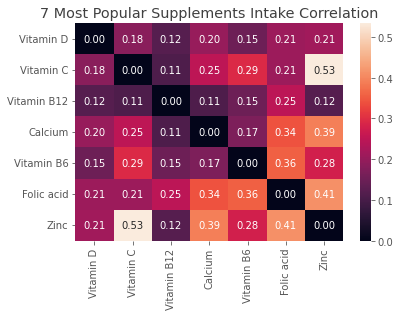

In [12]:
import seaborn as sns

popular_ones = df_dietary_prepare.iloc[:, 0:7]
popular_ones.columns = ["Vitamin D", "Vitamin C", "Vitamin B12", "Calcium", "Vitamin B6", "Folic acid", "Zinc"]
popular_corr = popular_ones.corr()
np.fill_diagonal(popular_corr.values, 0)
print("mean corr among popular ones: ", np.sum(popular_corr.sum())/(len(popular_corr) * (len(popular_corr)-1)))
ax = sns.heatmap(popular_corr, annot=True, fmt=".2f")
# ax.title('pearson correlation among top 7 popular supplements')
# fig = ax.get_figure()
# fig.savefig('top7_heatmap.png')
plt.title('7 Most Popular Supplements Intake Correlation', color=plt.get_cmap('Greys')(0.8))
plt.savefig('top7_heatmap.png', dpi=500,bbox_inches = 'tight')

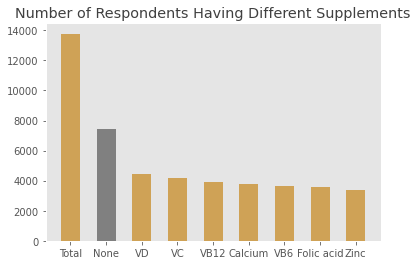

In [13]:
# colormap refer to https://matplotlib.org/stable/tutorials/colors/colormaps.html
num_bars = 9
x = np.linspace(0, 5*num_bars, num_bars)
y = [len(df_dietary), df_dietary.loc[df_dietary["DSD010"] == 2].count()[0]]
y.extend(count[0:7]) 
x_label=["Total", "None", "VD", "VC", "VB12", "Calcium", "VB6", "Folic acid", "Zinc"]
colors = [plt.get_cmap('BrBG')(0.25), 'grey'] + [plt.get_cmap('BrBG')(0.25)] * 7
plt.xticks(x, x_label)
plt.bar(x,y, width=3, color=colors)
plt.grid(False)
plt.title('Number of Respondents Having Different Supplements', color=plt.get_cmap('Greys')(0.8))
plt.savefig('dietary_barchart.png', dpi=500,bbox_inches = 'tight')
plt.show()

# Cross dataset correlation

## Correlations between pairs of continous variables

<BarContainer object of 9 artists>

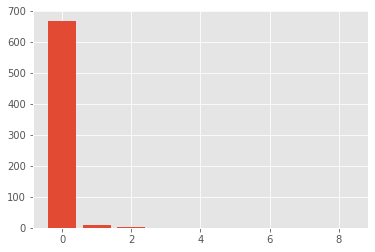

In [ ]:
df_corr = df_data.drop(columns = ["SEQN"]).corr(method = "spearman")
dfs = df_corr.stack()

corr_count = dict()
for corr in range(1, 10):
  corr_count[corr/10] = 0
  for a, v in zip(dfs.index, dfs):
    c1 = a[0]
    c2 = a[1]
    if c1 == c2 or check_which_data(c1) ==  check_which_data(c2) or abs(v) <corr/10:
      continue  
    corr_count[corr/10] += 1

plt.bar(np.arange(9), pd.Series(corr_count).values/2)

In [ ]:
print(corr_count)

{0.1: 1336, 0.2: 18, 0.3: 2, 0.4: 0, 0.5: 0, 0.6: 0, 0.7: 0, 0.8: 0, 0.9: 0}


In [ ]:
c = 0
for i, (a, v) in enumerate(zip(dfs.index, dfs)):
  if i > len(dfs)/2:
    break
  c1 = a[0]
  c2 = a[1]
  if c1 == c2 or check_which_data(c1) ==  check_which_data(c2) or abs(v) <0.22:
    continue  
  print(all_codes[c1], "(",c1,")-", check_which_data(c1), "is correlated with", all_codes[c2], "(",c2,")-",check_which_data(c2), "---",v)
  c += 1
print(c)

Total # of Dietary Supplements Taken ( DSDCOUNT )- diet is correlated with Number of foods/beverages reported ( DR1TNUMF )- nutrition --- 0.2308343099006234
Total # of Dietary Supplements Taken ( DSDCOUNT )- diet is correlated with POSTERIOR CARIES COUNT ( POSTERIOR_CARIES_COUNT )- dental --- 0.25023287256478755
Calcium (mg) ( DSQTCALC )- diet is correlated with POSTERIOR CARIES COUNT ( POSTERIOR_CARIES_COUNT )- dental --- 0.2516762159546641
Magnesium (mg) ( DSQTMAGN )- diet is correlated with POSTERIOR CARIES COUNT ( POSTERIOR_CARIES_COUNT )- dental --- 0.2309082596469845
Number of foods/beverages reported ( DR1TNUMF )- nutrition is correlated with Total # of Dietary Supplements Taken ( DSDCOUNT )- diet --- 0.2308343099006234
Caffeine (mg) ( DR1TCAFF )- nutrition is correlated with ANTERIOR CARIES COUNT ( ANTERIOR_CARIES_COUNT )- dental --- 0.2284445216299341
Caffeine (mg) ( DR1TCAFF )- nutrition is correlated with POSTERIOR CARIES COUNT ( POSTERIOR_CARIES_COUNT )- dental --- 0.316604

Caffiene is correlated with both anteriour and posterior caries, that is expected.

## Insights via grouping continous variables according to categorical variables

In [ ]:
dfgd = df_data.drop(columns = ["SEQN"]).groupby("DR1LANG").describe()

Text(0.5, 1.0, 'Mean (in gm) Caffeine consumptions of\ndifferent Language speaking groups')

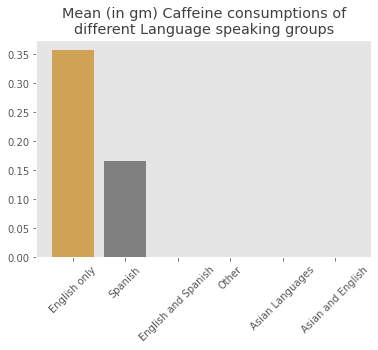

In [ ]:
num_bars = 9
x = dfgd[("DSQTCAFF", "mean")].index.values
y = dfgd[("DSQTCAFF", "mean")].values
# y.extend(count[0:7]) 
x_label=["English only", "Spanish", "English and Spanish", "Other", "Asian Languages", "Asian and English"]
colors = [plt.get_cmap('BrBG')(0.25), 'grey'] + [plt.get_cmap('BrBG')(0.25)] * 7
plt.xticks(x, x_label, rotation = 45)
plt.bar(x,y, color=colors)
plt.grid(False)
plt.title('Mean (in gm) Caffeine consumptions of\ndifferent Language speaking groups', color=plt.get_cmap('Greys')(0.8))

In [ ]:
dfgg = df_data.drop(columns = ["SEQN"]).groupby(["DSD010", "DR1MRESP"]).size()
a = []
for i in range (1, 12):
  if i == 4:
    continue
  a.append(dfgg[(2, i)])
a = np.array(a)/df_data.drop(columns = ["SEQN"]).groupby("DR1MRESP").count()["DSDCOUNT"].values

Text(0.5, 1.0, '% distribution of respondents who take supplements')

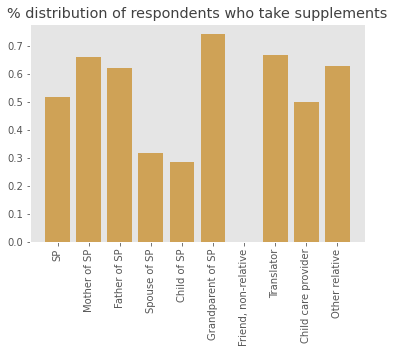

In [ ]:
y = a
x = np.arange(1, len(y)+1)
num_bars = len(x)
# y.extend(count[0:7]) 
x_label=['SP',
 'Mother of SP',
 'Father of SP',
 'Spouse of SP',
 'Child of SP',
 'Grandparent of SP',
 'Friend, non-relative',
 'Translator',
 'Child care provider',
 'Other relative']
colors = [plt.get_cmap('BrBG')(0.25)] * len(x)
plt.xticks(x, x_label, rotation = 90)
plt.bar(x,y, color=colors)
plt.grid(False)
plt.title('% distribution of respondents who take supplements', color=plt.get_cmap('Greys')(0.8))

In [ ]:
dfgd = df_data.drop(columns = ["SEQN"]).groupby("DR1MRESP").describe()

Text(0.5, 1.0, 'Mean (in mg) Phosphorous Supplements taken')

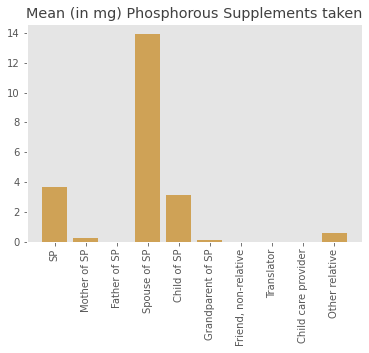

In [ ]:
y = dfgd[("DSQTPHOS", "mean")].values
x = np.arange(1, len(y)+1)
num_bars = len(x)
# y.extend(count[0:7]) 
x_label=['SP',
 'Mother of SP',
 'Father of SP',
 'Spouse of SP',
 'Child of SP',
 'Grandparent of SP',
 'Friend, non-relative',
 'Translator',
 'Child care provider',
 'Other relative']
colors = [plt.get_cmap('BrBG')(0.25)] * len(x)
plt.xticks(x, x_label, rotation = 90)
plt.bar(x,y, color=colors)
plt.grid(False)
plt.title('Mean (in mg) Phosphorous Supplements taken', color=plt.get_cmap('Greys')(0.8))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as plt
from preprocess_dental import preprocess_dental_data
from data_preprocess import preprocess


In [ ]:
data = preprocess_dental_data(usage='01', set_index=True, drop_all_na=True, skipna=False)
data.describe()

In [ ]:
colors = [plt.pyplot.get_cmap('BrBG')(0.25), 'grey'] + [plt.pyplot.get_cmap('BrBG')(0.25)] * 7

In [ ]:
data['TOTAL_CARIES_COUNT'].plot.hist(color=colors)

In [ ]:
data['TOTAL_SEALANT_COUNT'].plot.hist(color=colors)

In [ ]:
data['ROOT_CARIES'].plot.hist()

In [ ]:
data['OTHER_NON_CARIOUS_ROOT_LESION'].plot.hist()

In [ ]:
data['TOTAL_SIMPLE_01'].plot.hist()

In [ ]:
data['SERIOUS_01'].plot.hist(color=colors)